In [56]:
import os
import glob
import numpy as np
from PIL import Image

label_folder = "yolo-dataset-rennes/train/labels"
image_folder = "yolo-dataset-rennes/train/images"

def polygon_to_bbox(polygon):
    x_coords = polygon[::2]
    y_coords = polygon[1::2]
    xmin, xmax = min(x_coords), max(x_coords)
    ymin, ymax = min(y_coords), max(y_coords)
    return xmin, ymin, xmax, ymax

def bbox_to_yolo(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = (xmin + xmax) / 2.0 
    y_center = (ymin + ymax) / 2.0
    width = (xmax - xmin)
    height = (ymax - ymin)
    return x_center, y_center, width, height

def convert_seg_to_bbox_yolo(label_path, image_path):
    new_lines = []
    img = Image.open(image_path)
    img_w, img_h = img.size

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = list(map(float, line.strip().split()))
        class_id = int(parts[0])
        coords = parts[1:]
        if len(coords) >= 6:
            xmin, ymin, xmax, ymax = polygon_to_bbox(coords)
            x_center, y_center, width, height = bbox_to_yolo(xmin, ymin, xmax, ymax, img_w, img_h)
            new_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
            new_lines.append(new_line)

    with open(label_path, "w") as f:
        f.writelines(new_lines)

# 🔁 Apply to all files
for label_path in glob.glob(os.path.join(label_folder, "*.txt")):
    base_name = os.path.splitext(os.path.basename(label_path))[0]
    image_path = os.path.join(image_folder, base_name + ".jpg")
    if not os.path.exists(image_path):
        image_path = os.path.join(image_folder, base_name + ".png")  # try PNG fallback
    if os.path.exists(image_path):
        convert_seg_to_bbox_yolo(label_path, image_path)
    else:
        print(f"⚠️ Image not found for {base_name}")


In [61]:
import os
import glob
from collections import Counter, defaultdict

label_folder = "yolo-dataset-rennes/train/labels"

class_counter = Counter()
file_counter = defaultdict(set)  # class_id → set of filenames

txt_files = glob.glob(os.path.join(label_folder, "*.txt"))
total_labels = 0

for label_file in txt_files:
    with open(label_file, "r") as f:
        lines = f.readlines()
    total_labels += len(lines)
    filename = os.path.basename(label_file)

    for line in lines:
        if not line.strip():
            continue
        parts = line.strip().split()
        class_id = int(parts[0])
        class_counter[class_id] += 1
        file_counter[class_id].add(filename)

# --- OUTPUT ---

print(f"📁 Total label files: {len(txt_files)}")
print(f"🔢 Total annotations: {total_labels}")
print(f"\n📊 Per-class statistics:")

for class_id in sorted(class_counter):
    print(f"  Class {class_id}: {class_counter[class_id]} instances in {len(file_counter[class_id])} files")


📁 Total label files: 2185
🔢 Total annotations: 8709

📊 Per-class statistics:
  Class 1: 1710 instances in 466 files
  Class 2: 548 instances in 160 files
  Class 4: 1856 instances in 489 files
  Class 5: 777 instances in 184 files
  Class 7: 3818 instances in 913 files


In [58]:
classes_to_remove = {0, 3, 6}
label_folder = "yolo-dataset-rennes/train/labels"

def filter_labels(input_path, output_path=None):
    output_path = output_path or input_path
    with open(input_path, 'r') as f:
        lines = f.readlines()

    filtered = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        if class_id not in classes_to_remove:
            filtered.append(line)

    with open(output_path, 'w') as f:
        f.writelines(filtered)

# Apply to all
for label_path in glob.glob(os.path.join(label_folder, '*.txt')):
    filter_labels(label_path, )


In [62]:
import os
import cv2
import glob
import numpy as np
from random import choice
import matplotlib.pyplot as plt

# --- CONFIG ---
label_folder = "yolo-dataset-rennes/train/labels"
image_folder = "yolo-dataset-rennes/train/images"

class_names = ["class_0", "class_1", "class_2"]  # optional
display_segmentation = True  # False = draw bbox from segmentation


def draw_yolo_annotations(img_path, label_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Could not read image: {img_path}")
        return

    h, w = img.shape[:2]
    if not os.path.exists(label_path):
        print(f"⚠️ No label file: {label_path}")
        return

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        coords = list(map(float, parts[1:]))

        if len(coords) == 4:
            # --- BBOX ---
            xc, yc, bw, bh = coords
            x1 = int((xc - bw / 2) * w)
            y1 = int((yc - bh / 2) * h)
            x2 = int((xc + bw / 2) * w)
            y2 = int((yc + bh / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = class_names[class_id] if class_id < len(class_names) else str(class_id)
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        elif len(coords) >= 6:
            # --- SEGMENTATION POLYGON ---
            points = np.array(coords).reshape(-1, 2)
            points[:, 0] *= w  # x
            points[:, 1] *= h  # y
            points = points.astype(int)
            if display_segmentation:
                cv2.polylines(img, [points], isClosed=True, color=(255, 0, 0), thickness=2)
            else:
                x1, y1 = np.min(points, axis=0)
                x2, y2 = np.max(points, axis=0)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 255), 2)

            label = class_names[class_id] if class_id < len(class_names) else str(class_id)
            cv2.putText(img, label, tuple(points[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# --- BROWSE THROUGH IMAGES ---
image_paths = sorted(glob.glob(os.path.join(image_folder, "*.*")))




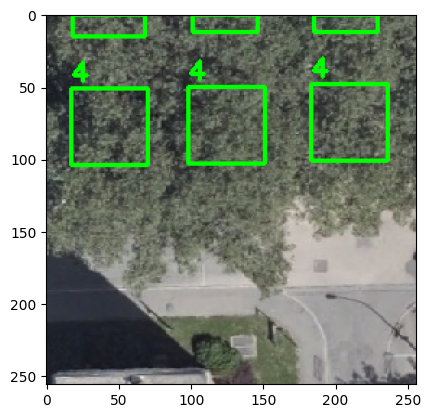

In [63]:
img_path = choice(image_paths)
fname = os.path.splitext(os.path.basename(img_path))[0]
label_path = os.path.join(label_folder, fname + ".txt")
draw_yolo_annotations(img_path, label_path)

In [66]:
import os
import glob

label_folder = "yolo-dataset-rennes/train/labels"

txt_files = glob.glob(os.path.join(label_folder, "*.txt"))

for label_file in txt_files:
    with open(label_file, "r") as f:
        lines = f.readlines()

    # Strip whitespaces and remove duplicates
    unique_lines = list(dict.fromkeys([line.strip() for line in lines if line.strip()]))

    with open(label_file, "w") as f:
        for line in unique_lines:
            f.write(line + "\n")

    print(f"✅ Cleaned {os.path.basename(label_file)}: {len(lines)} → {len(unique_lines)} lines")


✅ Cleaned 519293_363971.txt: 1 → 1 lines
✅ Cleaned 519285_364000.txt: 3 → 3 lines
✅ Cleaned 519293_363973.txt: 2 → 2 lines
✅ Cleaned 519286_363999.txt: 5 → 5 lines
✅ Cleaned 519293_363972.txt: 1 → 1 lines
✅ Cleaned 519286_364000.txt: 5 → 5 lines
✅ Cleaned 519293_363981.txt: 3 → 3 lines
✅ Cleaned 519286_364006.txt: 3 → 3 lines
✅ Cleaned 519293_363999.txt: 5 → 5 lines
✅ Cleaned 519287_363999.txt: 6 → 6 lines
✅ Cleaned 519293_364000.txt: 7 → 7 lines
✅ Cleaned 519287_364007.txt: 2 → 2 lines
✅ Cleaned 519295_364005.txt: 12 → 12 lines
✅ Cleaned 519287_364021.txt: 1 → 1 lines
✅ Cleaned 519296_363999.txt: 3 → 3 lines
✅ Cleaned 519287_364023.txt: 1 → 1 lines
✅ Cleaned 519296_364005.txt: 5 → 5 lines
✅ Cleaned 519288_363977.txt: 1 → 1 lines
✅ Cleaned 519296_364006.txt: 9 → 9 lines
✅ Cleaned 519288_363978.txt: 2 → 2 lines
✅ Cleaned 519296_364007.txt: 7 → 7 lines
✅ Cleaned 519288_363979.txt: 3 → 3 lines
✅ Cleaned 519296_364008.txt: 6 → 6 lines
✅ Cleaned 519288_363994.txt: 2 → 2 lines
✅ Cleaned 5192

In [2]:
def yolo_seg_to_vgg(image_file, txt_file):
    """Convert a single YOLOv8 segmentation txt to VGG format."""
    img = Image.open(image_file)
    w, h = img.size
    
    regions = {}
    with open(txt_file, 'r') as f:
        for i, line in enumerate(f):
            coords = list(map(float, line.strip().split()) )
            class_id = int(coords[0]) 
            points = coords[1:]  # all subsequent points are x, y pairs
            all_x = []
            all_y = []

            for j in range(0, len(points), 2):
                x = int(points[j] * w)
                y = int(points[j+1] * h)
                
                all_x.append(x)
                all_y.append(y)

            regions[str(i)] = {
                "shape_attributes": {
                    "name": "polygon",
                    "all_points_x": all_x,
                    "all_points_y": all_y
                },
                "region_attributes": {
                    "label": CLASSES[class_id]
                }
            }
    return {
        "filename": os.path.basename(image_file),
        "size": os.path.getsize(image_file),
        "regions": regions
    }


import json
from PIL import Image
import numpy as np

# Define your classes here
CLASSES = ['BOULEAU', 'CERISIER', 'CHARME', 'MURIER A PAPIER', 'PLATANE', 'POIRIER', 'POMMIER', 'TILLEUL']

def result_to_vgg(result, image_file):
    """Convert a single ultralytics result to VGG format."""
    img = Image.open(image_file)
    w, h = img.size
    
    regions = {}
    masks = result.masks  # Masks object
    for i, mask in enumerate(masks.xy):
        points = mask  # ndarray of shape (N, 2)

        all_x = points[:, 0].tolist()
        all_y = points[:, 1].tolist()

        class_id = int(result.boxes.cls[i])  # Class index
        label = CLASSES[class_id]

        regions[str(i)] = {
            "shape_attributes": {
                "name": "polygon",
                "all_points_x": all_x,
                "all_points_y": all_y
            },
            "region_attributes": {
                "label": label
            }
        }
    return {
        "filename": image_file,
        "size": int(os.path.getsize(image_file)),
        "regions": regions
    }

    import json
import os


def result_boxes_to_vgg(result, img_size):
    """Convert a single ultralytics result (bounding boxes) to VGG format."""
    # img = Image.open(image_file)
    w, h = img_size
    image_file = result.path
    regions = {}
    boxes = result.boxes
    
    for i, box in enumerate(boxes):
        # box.xyxy[0] is a tensor [xmin, ymin, xmax, ymax]
        xmin, ymin, xmax, ymax = box.xyxy[0].tolist()
        class_id = int(box.cls[0])  # Class index
        label = CLASSES[class_id]

        regions[str(i)] = {
            "shape_attributes": {
                "name": "rect",
                "x": int(xmin),
                "y": int(ymin),
                "width": int(xmax - xmin),
                "height": int(ymax - ymin),
            },
            "region_attributes": {
                "label": label
            }
        }
    return {
        "filename": os.path.basename(image_file),
        "size": os.path.getsize(image_file),
        "regions": regions
    }



In [3]:
from ultralytics import YOLO

model = YOLO('ARBRES/exp25/weights/best.pt')
imgs_dir = 'castanet-tuiles'

In [4]:
results = model.predict(imgs_dir, conf=.45, iou=0.5, imgsz=256, batch=32)


image 1/4123 /home/sagemaker-user/plantes-invasives/castanet-tuiles/20_528604_383230.jpg: 256x256 1 TILLEUL, 1.9ms
image 2/4123 /home/sagemaker-user/plantes-invasives/castanet-tuiles/20_528604_383231.jpg: 256x256 (no detections), 1.9ms
image 3/4123 /home/sagemaker-user/plantes-invasives/castanet-tuiles/20_528605_383230.jpg: 256x256 (no detections), 1.9ms
image 4/4123 /home/sagemaker-user/plantes-invasives/castanet-tuiles/20_528605_383231.jpg: 256x256 2 TILLEULs, 1.9ms
image 5/4123 /home/sagemaker-user/plantes-invasives/castanet-tuiles/20_528605_383232.jpg: 256x256 2 TILLEULs, 1.9ms
image 6/4123 /home/sagemaker-user/plantes-invasives/castanet-tuiles/20_528606_383230.jpg: 256x256 (no detections), 1.9ms
image 7/4123 /home/sagemaker-user/plantes-invasives/castanet-tuiles/20_528606_383231.jpg: 256x256 1 CERISIER, 1.9ms
image 8/4123 /home/sagemaker-user/plantes-invasives/castanet-tuiles/20_528606_383232.jpg: 256x256 (no detections), 1.9ms
image 9/4123 /home/sagemaker-user/plantes-invasives/

In [6]:
len(results)

4123

In [8]:
[int(x) for x in results[0].boxes.xyxy[0].tolist()]

[635, 443, 849, 659]

In [9]:
vgg = {}
for result in results:
    if len(result) == 0 :
        continue
    fn = os.path.basename(result.path)
    vgg[fn] = result_boxes_to_vgg(result, (1024,1024))

In [10]:
len(vgg)

616

In [11]:
with open('test-arbres-castanet.json', 'w')as f:
    json.dump(vgg, f)

In [13]:
import shutil

for fn in  vgg:
    shutil.copy(f'castanet-tuiles/{fn}', f'only-castanet-images/{fn}')

In [15]:
!sudo apt install zip ; zip -r images-castanet.zip only-castanet-images

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  zip
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 176 kB of archives.
After this operation, 544 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 zip amd64 3.0-12build2 [176 kB]
Fetched 176 kB in 1s (268 kB/s)m
debconf: delaying package configuration, since apt-utils is not installed

78Selecting previously unselected package zip.
(Reading database ... 14553 files and directories currently installed.)
Preparing to unpack .../zip_3.0-12build2_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 20%] [###########...............................................] 8Unpacking zip (3.0-12build2) ...
7Progress: [ 40%] [#######################...................................] 8Setting up zip (3.0-12build2) ...
7P